# 3F ice shelf model (flow, flexure, fracture)
This notebook is similar to the [coupled flow/viscous flexure notebook](https://github.com/chrismiele/weird_flex/blob/main/coupled_flow_flexure/coupled_flow_flexure_viscous.ipynb), but it incorporates the fracture density description of [Albrecht and Levermann](https://www.cambridge.org/core/journals/journal-of-glaciology/article/fracture-field-for-largescale-ice-dynamics/ED82A8928F6C65EFA3817CC02745956D). Fracture density softens the effective flow viscosity exactly as previously implemented by icepack and described [here](https://icepack.github.io/notebooks/tutorials/02-synthetic-ice-shelf/). 

The key difference between icepack's existing implementation and this one is that we use the flexural strain rate (which is generally not depth-invariant) to force fracture, rather than the depth-invariant strain rate from SSA flow. To produce fracture density as a depth-invariant scalar field, we simply depth-average the principal extensional strain rate from the flexure field, via

$$\overline{\dot{\varepsilon_1}} = \frac{1}{H}\int_{-\frac{H}{2}}^\frac{H}{2}\dot{\varepsilon}_1d\zeta = $$

$$ = \frac{1}{H}\int_{-\frac{H}{2}}^0\lambda_2\zeta d\zeta + \frac{1}{H}\int_0^\frac{H}{2}\lambda_1\zeta d\zeta = $$

$$ = \frac{1}{8}H(\lambda_1 - \lambda_2),$$

where $\lambda_1 > \lambda_2$ are the eigenvalues of the flexural strain rate $\dot{\varepsilon} = -\nabla^2\dot{\eta}$. The method of Albrecht and Levermann is then applied with $\overline{\dot{\varepsilon}}$ as the principal extension.

## Imports

In [1]:
path = '/home/sermilik/firedrake_stuff/figures/flow_flexure' #modify to preferred destination for saving figures

from abc import ABC
from firedrake import *
import icepack
from icepack.calculus import sym_grad, grad, div, FacetNormal
from icepack.models.viscosity import membrane_stress
from icepack.optimization import MinimizationProblem, NewtonSolver
from icepack.utilities import eigenvalues, default_solver_parameters
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import os
import tqdm

## Mesh, function spaces, trial and test functions

The shelf will be rectangular, with length ```Lx``` and width ```Ly```. Deflection will be solved over Argyris elements of order 5, and velocity will be solved over CG elements of order 2. 

In [2]:
nx, ny = 200, 1 #number of elements in x, y
Lx, Ly = 6000, 6000 #length, width in meters
mesh = RectangleMesh(nx, ny, Lx, Ly)
x, y = SpatialCoordinate(mesh)

Q1 = FunctionSpace(mesh, 'Argyris', 5) #Argyris elements for solving 4th order flexure problem
Q2 = FunctionSpace(mesh, 'CG', 2) #CG elements for icepack's prognostic solve, which does not appreciate Argyris elements
V = VectorFunctionSpace(mesh, 'CG', 2)  #CG elements for solving SSA problem
S = TensorFunctionSpace(mesh, 'DG', 1) #DG elements for interpolating tensors arising from the velocity field

η = Function(Q1) #deflection rate
w = TestFunction(Q1)
ddη = grad(grad(η)) 
ddw = grad(grad(w))
Δη = div(grad(η)) 
Δw = div(grad(w)) 

u = Function(V) #velocity
v = TestFunction(V) #note the Roman v, not to be confused with Greek ν introduced below

## Physical constants, shelf geometry

In [3]:
from icepack.constants import year #number of seconds in a year
ρ_i = 917 #ice density value consistent with icepack's, but in kg/m^3
ρ_w = 1024 #water density consistent with icepack, but in kg/m^3
ϱ = ρ_i/ρ_w #density ratio
g = 9.81 #gravity in N/kg
T = Constant(273.15) #temperature (K). 273.15 is freezing
A = icepack.rate_factor(T) #A from Glen's law
ν_f = 1e17/year #viscosity in the flexure equations need not equal the viscosity from flow

H_gl = 200 #thickness at upstream boundary (m)
thick_grad = 0 #thickness gradient 
H0 = project(H_gl + thick_grad*x, Q2) #initial thickness projected onto CG elements
b0 = project(-ϱ*H0, Q2) #initial basal elevation
s0 = project(H0 + b0, Q2) #initial surface elevation

damage_source = 'flexure' #damage can come from the flexure field ('flexure') or the flow field ('flow')

## Modify some icepack modules to solve non-equilibrium SSA

Unlike the classic SSA, this variation does not assume the shelf to be exactly at flotation. We'll tweak icepack's ```gravity``` and ```terminus``` modules to allow the driving stress and terminal cliff boundary condition to reflect this departure from equilibrium. We'll also modify the ```viscosity_depth_averaged``` functional to allow for damage softening, and write a damage transport similar to [this one](https://github.com/chrismiele/weird_flex/blob/main/fracture/zero_stress_damage_transport.ipynb).

Temporarily hard-coding a TransportSolver to advect the damage field, but this will soon be replaced by built-in functionality. 

In [4]:
ρ_I, ρ_W = ρ_i/1e6/year**2, ρ_w/1e6/year**2 #put into icepackese
G = g*year**2

def gravity(**kwargs): #see RHS of Eq. 44 in MacAyeal et al. (2021)
    u, h, b = itemgetter('velocity', 'thickness', 'base')(kwargs)
    return -0.5* ρ_I*G*inner(grad(h**2), u) + 0.5*ρ_W*G* inner(grad(b**2), u)

def terminus(**kwargs): #see Eq. 45 from MacAyeal et al. (2021)
    u, h, b = itemgetter('velocity', 'thickness', 'base')(kwargs)
    mesh = u.ufl_domain()
    ν = FacetNormal(mesh)
    return 0.5*ρ_I*G*h**2*inner(u, ν) - 0.5*ρ_W*G*b**2*inner(u, ν)

def viscosity_depth_averaged(**kwargs): #icepack's viscosity_depth_averaged functional, but with damage softening
    n = 3 #glen's law exponent
    u, h, A, D = itemgetter('velocity', 'thickness', 'fluidity', 'damage')(kwargs)
    A_damaged = (1 - D)**(-n)*A
    return icepack.models.viscosity.viscosity_depth_averaged(velocity = u, thickness = h, 
                                                             fluidity = A_damaged)

def effective_viscosity(**kwargs): #also define a function that returns the effective viscosity
    n = 3
    u, D = itemgetter('velocity', 'damage')(kwargs)
    ε = sym(grad(u))
    ε_min = Constant(kwargs.get('strain_rate_min', icepack.constants.strain_rate_min))
    ε_e = icepack.models.viscosity._effective_strain_rate(ε, ε_min) 
    A_damaged = (1 - D)**(-n)*A
    ν = 1/2*A_damaged**(-1/n)*ε_e**(1/n - 1) #effective viscosity in MPa*yrs
    return ν*1e6 #return ν in units of Pa*yrs

#####################################
#####################################
### transport equation and solver ###
#####################################
#####################################

# Copyright (C) 2023 by Daniel Shapero <shapero@uw.edu>
#
# This file is part of icepack.
#
# icepack is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# The full text of the license can be found in the file LICENSE in the
# icepack source directory or at <http://www.gnu.org/licenses/>.

###############################################
###############################################
### copy/paste icepack's transport equation ###
###############################################
###############################################

class TransportEquation(ABC):
    def __init__(self, field_name, conservative):
        self._field_name = field_name
        self._conservative = conservative

    def flux(self, **kwargs):
        keys = (self._field_name, "velocity")
        q, u = itemgetter(*keys)(kwargs)
        q_inflow = kwargs.get(f"{self._field_name}_inflow", Constant(0.0))

        if q.ufl_shape != ():
            raise NotImplementedError(
                "Transport equation only implemented for scalar problems!"
            )

        Q = q.function_space()
        φ = TestFunction(Q)

        mesh = Q.mesh()
        n = FacetNormal(mesh)
        #ds = ds if mesh.layers is None else ds_v

        if self._conservative:
            flux_cells = -inner(q * u, grad(φ)) * dx
        else:
            flux_cells = -q * div(u * φ) * dx

        flux_out = q * max_value(0, inner(u, n)) * φ * ds
        flux_in = q_inflow * min_value(0, inner(u, n)) * φ * ds

        if q.ufl_element().family() == "Discontinuous Lagrange":
            f = q * max_value(0, inner(u, n))
            flux_faces = (f("+") - f("-")) * (φ("+") - φ("-")) * dS
            return flux_cells + flux_faces + flux_out + flux_in

        return flux_cells + flux_out + flux_in

    def sources(self, **kwargs): #tweaking this to only permit (thickness, thickness_accumulation), (damage, damage_accumulation), etc.
        keys = (self._field_name, "{}_accumulation".format(self._field_name))
        ψ, a = itemgetter(*keys)(kwargs)
        φ = TestFunction(ψ.function_space())
        return a * φ * dx

#################################################################
#################################################################
### essentially copy/paste the relevant bits from flow_solver ###
#################################################################
#################################################################

class TransportSolver:
    def __init__(self, model, **kwargs):
        
        self._model = model
        self._fields = {}

        # Prepare the prognostic solver
        prognostic_parameters = kwargs.get(
            "prognostic_solver_parameters", default_solver_parameters
        )

        self._prognostic_solver = LaxWendroff(
            model, self._fields, prognostic_parameters
        )

    @property
    def model(self):
        r"""The physics model that this object solves"""
        return self._model

    @property
    def fields(self):
        r"""Dictionary of all fields that are part of the simulation"""
        return self._fields

    def prognostic_solve(self, dt, **kwargs):
        r"""Solve the prognostic model physics for the new value of the chosen scaler field"""
        return self._prognostic_solver.solve(dt, **kwargs)

class LaxWendroff:
    def __init__(self, model, fields, solver_parameters):
        self._model = model
        self._fields = fields
        self._solver_parameters = solver_parameters

    def setup(self, **kwargs):
        r"""Create the internal data structures that help reuse information
        from past prognostic solves"""
        for name, field in kwargs.items():
            if name in self._fields.keys():
                self._fields[name].assign(field)
            else:
                if isinstance(field, Constant):
                    self._fields[name] = Constant(field)
                elif isinstance(field, Function):
                    self._fields[name] = field.copy(deepcopy=True)
                else:
                    raise TypeError(
                        "Input %s field has type %s, must be Constant or Function!"
                        % (name, type(field))
                    )

        dt = Constant(1.0)
        ψ = self._fields[self._model._field_name] #generalized from thickness h to scalar field ψ
        u = self._fields["velocity"]
        ψ_0 = ψ.copy(deepcopy=True)

        Q = ψ.function_space()
        mesh = Q.mesh()
        n = FacetNormal(mesh)
        outflow = max_value(0, inner(u, n))
        inflow = min_value(0, inner(u, n))

        # Additional streamlining terms that give 2nd-order accuracy
        q = TestFunction(Q)
        #ds_ = ds if mesh.layers is None else ds_v
        flux_cells = -div(ψ * u) * inner(u, grad(q)) * dx
        flux_out = div(ψ * u) * q * outflow * ds
        flux_in = div(ψ_0 * u) * q * inflow * ds
        d2ψ_dt2 = flux_cells + flux_out + flux_in

        sources = self._model.sources(**self._fields)
        flux = self._model.flux(**self._fields)
        dψ_dt = sources - flux
        F = (ψ - ψ_0) * q * dx - dt * (dψ_dt + 0.5 * dt * d2ψ_dt2)

        problem = NonlinearVariationalProblem(F, ψ)
        self._solver = NonlinearVariationalSolver(
            problem, solver_parameters=self._solver_parameters
        )

        self._ψ_old = ψ_0
        self._timestep = dt

    def solve(self, dt, **kwargs):
        r"""Compute the evolution of the chosen scalar field after time `dt`"""
        if not hasattr(self, "_solver"):
            self.setup(**kwargs)
        else:
            for name, field in kwargs.items():
                self._fields[name].assign(field)

        ψ = self._fields[self._model._field_name]
        self._ψ_old.assign(ψ)
        self._timestep.assign(dt)
        self._solver.solve()
        return ψ.copy(deepcopy=True)

## Set up the solver

We'll apply the flow-flexure model to the simplest case of a shelf in longitudinal extension. This is achieved by assigning the lateral boundaries in the flow solver to be ```side_wall_ids``` with friction coefficient zero. 

To provide a load for the flexure solver, surface mass balance is chosen to melt out a lake in the shape of a Gaussian curve. 

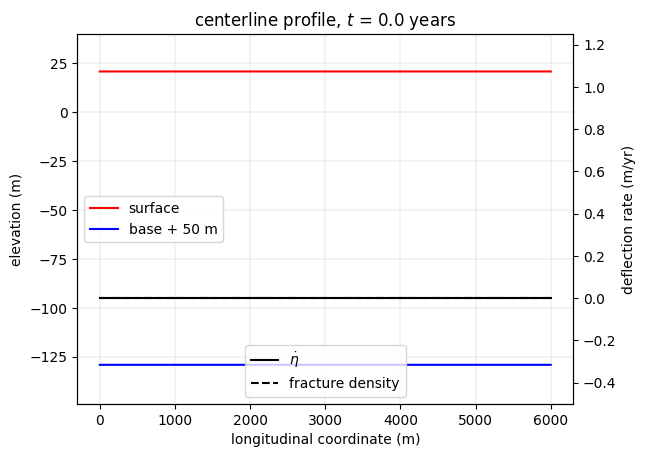

In [5]:
################################
################################
### parameters for iteration ###
################################
################################

Δt = 1/2 #length of timestep in years
num_timesteps = int(50/Δt) #spin up for 50 years

##################################
##################################
### parameters for flow solver ###
##################################
##################################

ux_gl = 100 #upstream boundary boundary condition in meters per year
u0 = project(as_vector([ux_gl, 1e-50]), V) #initial velocity (u_x, u_y) for imposing Dirichlet BCs

opts = {
    'dirichlet_ids': [1], #boundaries are labeled (1, 2, 3, 4) = (upstream, downstream, left, right)
    'side_wall_ids': [3, 4],
    'ice_front_ids': [2],
    'diagnostic_solver_type': 'petsc',
    'diagnostic_solver_parameters': {
        'ksp_type': 'cg',
        'pc_type': 'mg',
        'pc_mg_cycle_type': 'w',
        'snes_line_search_type': 'cp',
    },
    'prognostic_solver_parameters': {
        'ksp_type': 'gmres',
        'pc_type': 'ilu',
    },
}

flow_model = icepack.models.IceShelf(gravity = gravity, terminus = terminus, #model is icepack's SSA, but with our own physics
                                 viscosity = viscosity_depth_averaged)
flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

damage_model = TransportEquation(field_name = 'damage', conservative = False)
damage_solver = TransportSolver(damage_model, **opts)

#####################################
#####################################
### parameters for flexure solver ###
#####################################
#####################################

α = 1e10 #arbitrary large number for penalty method
a_x = 2*exp(-1/2*((x - Lx/2)/400)**2) #impose an ablation rate (m/yr) as a gaussian curve
a = project(-a_x, Q2) 

#############################
#############################
### plot initial geometry ###
#############################
#############################

os.chdir(path) #for saving figures
X = np.array([(k, Ly/2) for k in range (Lx+1)]) #along-flow line for getting geometry profiles
s0_profile = s0.at(X, tolerance = 1e-10)
b0_profile = np.array(project(b0 + 50, Q2).at(X, tolerance = 1e-10)) #add 25 meters to the basal profile for a better plot window

plt.figure()
plt.title('centerline profile, $t$ = 0.0 years')
plt.plot(s0_profile, color='red', label = 'surface')
plt.plot(b0_profile, color='blue', label = 'base + 50 m')
plt.legend(loc = 'center left')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('elevation (m)')
plt.ylim(int(-ϱ*H_gl - H_gl/10) + 50, int((1 - ϱ)*H_gl + H_gl/10))
plt.xticks(np.arange(0, Lx+1, 1000))
plt.grid(linewidth=0.2)
plt.twinx()
plt.ylabel('deflection rate (m/yr)')
plt.ylim(-0.5, 1.25)
plt.plot((0, Lx), (0, 0), color='k', label = '$\dot{η}$')
plt.plot((0, Lx), (0, 0), color='k', linestyle = 'dashed', label = 'fracture density')
plt.legend(loc='lower center')
plt.savefig('iteration_0')

## Iteratively solve the flow-flexure problem

We'll also save plots of the surface and basal elevation profiles, along the centerline, at each timestep. The final iteration is shown below. 

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.41s/it]


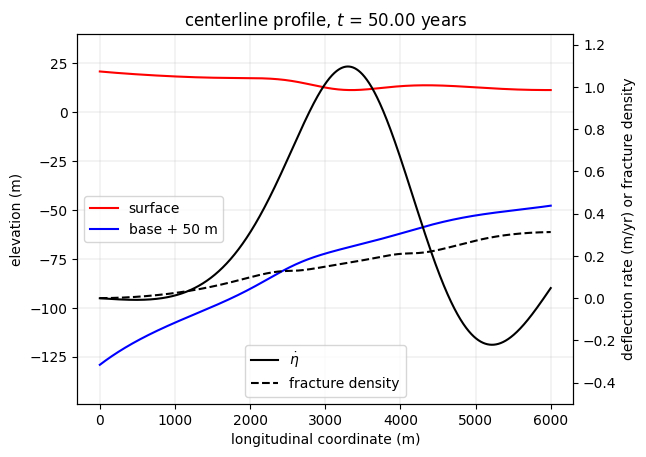

In [6]:
u, H, s, b = u0.copy(deepcopy=True), H0.copy(deepcopy=True), s0.copy(deepcopy=True), b0.copy(deepcopy=True) #initialize
D = Function(Q2)

for step in tqdm.trange(num_timesteps):
    
    #############################
    #############################
    ### get velocity solution ###
    #############################
    #############################
    
    u = flow_solver.diagnostic_solve(velocity = u, side_friction = Constant(0), 
                                thickness = H, base = b, fluidity = A, damage = D)
    
    ##################################
    ##################################
    ### dynamically thin the shelf ###
    ##################################
    ##################################
    
    s = flow_solver.prognostic_solve(Δt, thickness = s, velocity = u, #lower the surface 
                           thickness_inflow = s0, accumulation = Constant(0))
    
    b = flow_solver.prognostic_solve(Δt, thickness = b, velocity = u, #raise the base
                           thickness_inflow = b0, accumulation = Constant(0))

    H = project(s - b, Q2)

    ########################################
    ########################################
    ### calculate some useful parameters ###
    ########################################
    ########################################

    ν = effective_viscosity(velocity = u, damage = D) #in Pa*yrs, for consistency with icepack's velocity units
    ε = project(sym(grad(u)), S) #strain rate tensor, /yr
    τ = project(2*ν*ε, S) #depth-averaged deviatoric stress tensor in Pascals
    p = -tr(τ) + 1/2*ρ_i*g*H #depth-averaged pressure
    σ = τ - p*Identity(2) #depth-averaged net stress 

    ######################
    ######################
    ### flex the shelf ###
    ######################
    ######################

    h_ab = s + a*Δt + η*Δt - (1 - ϱ)*(H + a*Δt) #this will be the height above buoyancy once η is known

    #force flexure with surface mass balance (see Eq. 57a and 57c of MacAyeal et al. 2021)
    f = conditional(h_ab < 0, #if height above buoyancy is negative after flexing:
                    -ρ_w*g*h_ab, #f acts upward via buoyancy
                    -ρ_i*g*h_ab) #else: f acts downward via gravity
    
    #additionally force flexure with the velocity field, as in Eq. 57e 
    f += H*inner(σ, ddη*Δt) #Eq. 57e

    L = 1/6*ν_f*H**3*inner(ddη, ddw)*dx + 1/6*ν_f*H**3*Δη*Δw*dx - f*w*dx #note the different viscosity value
    L += 0.5*α**2*grad(η)[1]*grad(w)[1]*dx #dη/dy = 0 everywhere, for a proper 1D problem
    L += 0.5*α**2*h_ab*w*ds(1) #constrain h_ab = 0 on the upstream boundary via the penalty method
    L += 0.5*α**2*h_ab*w*ds(2) #and the same at the downstream boundary

    solve(L == 0, η) #η is returned in meters per year

    ###########################
    ###########################
    ### update damage field ###
    ###########################
    ###########################

    λ_1, λ_2 = eigenvalues(-grad(grad(η))) #principal flexural strain rates
    γ = 0.5 if damage_source == 'flow' else 0.5*ν_f/effective_viscosity(velocity = u, damage = 0) #damage rate, adjusted for flexural viscosity
    ε_1 = eigenvalues(ε)[0] if damage_source == 'flow' else 1/8*H*(λ_1 - λ_2) #depth-averaged principal extensional strain rate
    
    damage_accumulation = project(γ*ε_1*(1 - D), Q2) #damage accumulation term from Albrecht and Levermann

    D = damage_solver.prognostic_solve(Δt, velocity = u, damage = D, damage_inflow = Constant(0),
                                      damage_accumulation = damage_accumulation)

    #######################
    #######################
    ### adjust geometry ###
    #######################
    #######################
    
    b = project(b + η*Δt, Q2) #b is modified by the deflection
    s = project(s + a*Δt + η*Δt, Q2) #s is modified by deflection and surface mass balance 
    H = project(s - b, Q2) #new thickness

    #################################################
    #################################################
    ### make sure nothing has gone horribly wrong ###
    #################################################
    #################################################
    
    #if we've imposed too much surface melt, the surface may dip below the waterline
    #this breaks the mass conservation equations

    if s.dat.data.min() < 0:
        print('the surface went underwater! that sucks!')
        break
        
    #################
    #################
    ### save figs ###
    #################
    #################
    
    #at each step, save plots of the surface and basal elevation profiles along "X"
    s_profile = np.array(s.at(X, tolerance = 1e-10))
    b_profile = np.array(project(b + 50, Q2).at(X, tolerance = 1e-10))
    d_profile = np.array(D.at(X, tolerance = 1e-10))

    plt.figure()
    plt.title('centerline profile, $t$ = {:.2f} years'.format(step*Δt + Δt))
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('elevation (m)')
    plt.ylim(int(-ϱ*H_gl) - H_gl/10 + 50, int((1 - ϱ)*H_gl + H_gl/10))
    plt.plot(s_profile, color='red', label = 'surface')
    plt.plot(b_profile, color='blue', label = 'base + 50 m')
    plt.grid(linewidth = 0.2)
    plt.legend(loc = 'center left')
    plt.twinx()
    plt.plot(project(η, Q2).at(X, tolerance = 1e-10), color='k', label = '$\dot{η}$')
    plt.plot(d_profile, color='k', linestyle = 'dashed', label = 'fracture density')
    plt.ylabel('deflection rate (m/yr) or fracture density')
    plt.ylim(-0.5, 1.25)
    plt.legend(loc = 'lower center')
    plt.savefig('iteration_{}'.format(step + 1))
    if step < num_timesteps - 1:
        plt.close() #save all plots but only show the last iteration